# Model Building

In this notebook we will build and train five different models and compare their performance based on a custom cost function. Afterwards we will find the optimal cutoff point and make a discrete prediction on our unlabelled dataset.


### Machine Learning Algorithms
We decided to use 5 different machine learning algorithms:
- Logistic Regression
- Random Forrest
- XGBoost
- LightGBM
- CatBoost

Logistic Regressions are quite simply in what they do, but can sometimes still provide meaningful insights. I do not expect this algorithm to perform better than more sophisticated ones, such as XGBoost, but it might provide some insights on how much better more sophisticated algorithms can predict if items have been returned or not.

The Random Forrest XGBoost, and LightGBM are all decision tree algorithms, however there are some crucial differences between them. While Random Forrest builds each tree independently, XGBoost builds one tree at a time, making use of ensemble learning. Weak learners help to improve the shortcomings of other weak learners. 

LightGBM also utilizes ensemble learning, however it grows trees based on a leaf-wise growth algorithm instead of level-wise algorithm (like in XGBoost).

The last algorithm is CatBoost. It uses Minimal Variance Sampling (MVS)  in which weighted sampling happens in the tree-level and not in the split-level, which can lead to faster performance. Additionally it handles cateogrical variables quite differently, you can simply provide a list of categorical columns and the algorithm automatically one-hot-encodes the data. 
Since our dataset contains a lot of categorical variables with high cardinality, it might be a good idea to try this algorithm.

### Evaluation

As discussed in the introduction README, we will evaluate the performance of the models not based on typical evaluation metrics like the AUC-Score, but rather from a business perspective. The best model will not be the one that classifies with the highest accuracy, but rather the one that minimizes costs induced by misclassifications (FP, FN) and thus maximizes the revenue of the online shop.

According to the Assignment description the following  labels have been assigned for the return features:

| |Return| No Return |
|-- |--|--|
|Label in Dataset |1  |0 |
|Class Type| Positive |Negative  |

This is important to keep in mind, since the word `positive` usually has a "good" or, "positive" connotation. In our case however a user returning an item is rather considered a "bad" event. 

We were given an asymmetric error cost function, resulting in the following cost matrix:

<table>
<thead>
  <tr>
    <th></th>
    <th></th>
    <th colspan="2">Actual Class</th>
    <th></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td></td>
    <td></td>
    <td>Negative<br>(no return)</td>
    <td>Positive<br>(return)</td>
    <td></td>
  </tr>
  <tr>
    <td rowspan="2">Predicted<br>Class</td>
    <td>Negative <br>(no return)</td>
    <td>0</td>
    <td>0.5 * 5 * (3 + 0.1 . item_price)</td>
    <td></td>
  </tr>
  <tr>
    <td>Positive<br>(return)</td>
    <td>0.5 * item_price</td>
    <td>0</td>
    <td></td>
  </tr>
</tbody>
</table>

When the model predicted that a user will not return an item, but the user returns it, we costs for shipping emerge. The price of the item only plays a small part in the calculation of the FN costs. Even when the `item_price == 0` costs of 7,5 arise. This means that most costs by misclassifying FN are fixed costs. 

Conversely, when the model predicts that a user will return an item, but in reality the user will keep the item costs `0.5 * item_price` arise. This is based on prior studies that found that roughly 50% of users will cancel their order when a warning message is displayed. This costs scales linearly with the `item_price`, meaning the higher the `item_price`, the higher the costs for FP.

For a small `item_price`, the costs of FN are thus higher than the costs of FP.  There is an `item_price` threshold at which the costs of FP exceed the FN costs. This threshold can be calculated by equating the FN cost formula with the FP formula:
<pre>
0.5 * item_price = 0.5 * 5 * (3 + 0.1 * item_price) |&lt;-&gt;  
0.5 * item_price = 0.5 * ( 0.5v +15)                |&lt;-&gt;
0.5 * item_price = 0.25v + 7,5                      | -0.25v
0.25 * item_price =  7,5                            | : 0.25
item_price = 30
</pre>
This means that if the `item_price` is higher than 30, the costs of misclassifying a FP exceeds the costs of misclassifying a FN. 

Intuitively this also makes a lot of sense. When not ordering a low cost item, due to a FP, the lost revenue is rather small. When a user orders an item with a low cost but returns it (FN), the costs for the online shop are comparatively higher, since shipping the item back and forth mostly entails fixed costs. The opposite is true for high priced items (`item_price > 30`).

From our Data Visualisation Step we know that roughly 25% of all orders had an `item_price` lower than 30. This leads to the conclusion that we expect a good cutoff threshold to mostly lower the number of FP.

Equipped with this understanding we can now begin to design custom score functions and build and train five different models.

## Table of Contents
* [1. Import and Prepare Data](#import_data)
* [2. Modelling Helper Functions](#modelling_helper)
    * [2.1 Cost-Sensitive Helper Functions](#cost_sensitive)
* [3. Model Training](#model_training)
    * [3.1 Logistic Regression](#logistic_regression)
    * [3.2 Random Forrest](#random_forrest)
    * [3.3 XGBoost](#xgboost)
    * [3.4 LightGBM](#lightgbm)
    * [3.5 CatBoost](#catboost)
* [4. Model Comparison and Evaluation](#model_comparison)
    * [4.1 Partial Dependence Analysis](#pdp)
    * [4.2 SHAP](#shap)
* [5. Export Predictions](#export)
        


In [1]:
# Constants

# labels for confustion plot
confusion_lbs = ['Item Not Returned', 'Item Returned']

#Random Seed Constant
random_seed = 420

In [2]:
# Required Packages
#DS Packages
import pandas as pd
import numpy as np


#Utils
from dateutil.relativedelta import relativedelta
from datetime import datetime
import timeit # time model training time
import pickle # save data in pkl format
import os, sys
from tabulate import tabulate # package to display tables
import json # save and load json

#Data Viualization
import seaborn as sns
import matplotlib.pyplot as plt

#Metrics 
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.exceptions import NotFittedError
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score

#Test Train split
from sklearn.model_selection import train_test_split

# always display plots inline 
%matplotlib inline 

#set seaborn colors
sns.set(style='darkgrid')

#set numpy random seed 
np.random.seed(random_seed)

import warnings
warnings.filterwarnings('ignore')

## 1. Import and Prepare Data 
<a id="import_data"></a>

### Import Data

In [3]:
# Read processed data
df = pd.read_pickle('../data/03_processed/BADS_WS2021_known_processed_all_cols.pkl')
df_unknown = pd.read_pickle('../data/03_processed/BADS_WS2021_unknown_processed_all_cols.pkl')

In [4]:
# Make a copy of the df to prepare data differently for the catboost algorithm
df_cat_boost = df.copy()
df_unknown_cat_boost = df_unknown.copy()

### Data Prep and Train / Test Split

In [5]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], prefix=feature_to_encode)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [6]:
# drops unneeded columns:
def drop_cols(_df):
    _df = _df.drop(labels=['delivery_date',
                           'order_date',
                           'item_id',
                           'item_size',
                           'item_color',
                           'brand_id',
                           'user_id',
                           'user_dob',
                           'user_reg_date',
                           'is_first_purchase',                   
                          ]
                   , axis=1)
    return _df

In [7]:
df = drop_cols(df)
df_unknown = drop_cols(df_unknown)

In [8]:
X = df.loc[:, df.columns != 'return']
y = df['return']
categorical_columns = list(X.select_dtypes(include='category').columns)
numeric_columns = list(X.select_dtypes(exclude='category').columns)

# Make Test and Train Sets
data_splits = train_test_split(X, y, test_size=0.3, random_state=random_seed)
x_train, x_test, y_train, y_test = data_splits

# Make valuation Set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=random_seed) # 0.25 x 0.7 = 0.175



# check shapes of test / val/  train split
list(map(lambda x: x.shape, [X, y, x_train, x_val, x_test, y_train, y_val, y_test]))

[(100000, 15),
 (100000,),
 (52500, 15),
 (17500, 15),
 (30000, 15),
 (52500,),
 (17500,),
 (30000,)]

In [9]:
for cat in categorical_columns:
    x_train = encode_and_bind(x_train, cat)
    x_test = encode_and_bind(x_test, cat)
    x_val = encode_and_bind(x_val, cat)
    df_unknown = encode_and_bind(df_unknown, cat)

## Save feature names after one-hot encoding for feature importances plots
feature_names = list(x_train.columns.values)

#save eval set
eval_set = [(x_val, y_val)]

#### CatBoost Data Prep

In [10]:
# catboost labels to drop
labels=['delivery_date',
        'order_date',
        'item_id',
        'item_size',
        'item_color',
        'brand_id',
        'user_id',
        'user_dob',
        'user_reg_date',
        'is_first_purchase'
       ]

df_cat_boost = df_cat_boost.drop(labels=labels, axis=1)
df_unknown_cat_boost = df_unknown_cat_boost.drop(labels=labels, axis=1)

In [11]:
# For CatBoost 
X_cat = df_cat_boost.loc[:, df_cat_boost.columns != 'return']
y_cat = df_cat_boost['return']

categorical_columns_cat = list(X_cat.select_dtypes(include='category').columns)
numeric_columns_cat = list(X_cat.select_dtypes(exclude='category').columns)

data_splits = train_test_split(X_cat, y_cat, test_size=0.3, random_state=random_seed)

x_train_cat, x_test_cat, y_train_cat, y_test_cat = data_splits

x_train_cat, x_val_cat, y_train_cat, y_val_cat = train_test_split(x_train_cat, y_train_cat, test_size=0.25, random_state=random_seed) # 0.25 x 0.7 = 0.175
eval_set_cat = [(x_val_cat, y_val_cat)]

feature_names_cat = list(x_train_cat.columns.values)


## 2. Modelling Helper Functions
<a id="modelling_helper"></a>

**DISCLAIMER**: I made use of some functions by Kaggle User [JP](https://www.kaggle.com/para24) from [this](https://www.kaggle.com/para24/survival-prediction-using-cost-sensitive-learning) notebook to display classifier reports , since they display results of Classifiers in a beautiful way.
However, I only used the base version of his implementations and then heavily modified and extended them to my particular use case by for example:
- adding certain sections in the report func for cost-sensitive learning
- removing elements not needed in for this use case
- generating multiple confusion plots for different cutoffs
-...

In [12]:
def confusion_plot(matrices, labels=None, titles=None , nrows=1, ncols = 1):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    if nrows != 1 or ncols != 1:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
        for i, j, ax in zip(matrices, titles, axs.flat):
            # Plot heatmap
            ax.set_title(j)
            sns.heatmap(i, ax=ax, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=False)
            ax.set_xlabel('PREDICTED')
            ax.set_ylabel('ACTUAL')
    else:
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
        ax.set_title(titles[0])
        sns.heatmap(matrices[0], ax=ax, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=False)
        ax.set_xlabel('PREDICTED')
        ax.set_ylabel('ACTUAL')
    
    plt.close()
    
    return fig

In [13]:
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs,
                                 drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [14]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    p, r, thresh = list(p), list(r), list(thresh)
    p.pop()
    r.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [15]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance Measures')
    
    plt.close()
    
    return axis if ax else fig

In [16]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [17]:
# Calculating fpr and tpr manually at a given cutoff
# We will use this function to plot markers at distinct point across our line graph to see where the different cutoffs are along the graph
def tpr_fpr_calc(cutoff, yhat_prob, y_true):

    # temp variable giving distinct predictions based on the cutoff given as an input
    temp = (yhat_prob >= cutoff).astype(bool)

    # Create confusion matrix for this prediction
    cmat = metrics.confusion_matrix(y_true, temp)
    
    # Calculate FPR
    fpr = cmat[0,1] / (cmat[0,1] + cmat[0,0])

    # Calculate TPR
    tpr = cmat[1,1] / (cmat[1,1] + cmat[1,0])

    return tpr, fpr

In [18]:
def report(clf, x_train, y_train, x_test, y_test,
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    # Train Predictions and Accuracy
    train_predictions = clf.predict(x_train)
    train_acc = accuracy_score(y_train, train_predictions)
    
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    
    test_acc = accuracy_score(y_test, test_predictions)
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probs)
        
    train_avg_cost = calc_custom_cost_score(y_train.values, train_predictions, list(x_train['item_price']))
    test_avg_cost = calc_custom_cost_score(y_test.values, test_predictions, list(x_test['item_price']))
        
    ## Model Memory
    model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    print("Train Average Cost: ", train_avg_cost)
    print(" Test Average Cost: ", test_avg_cost)
    print("---------------------------------------------")
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    if verbose:
             
        print("\n================================> COST-SENSITIVE EVALUTATION <=====================================")

        cost_matrix = calc_custom_cost_score(y_test.values, test_predictions, list(x_test['item_price']), matrix = True)
        
        # Calibration curve
        plt.rcParams["figure.figsize"] = (12,6)

        # Calculate calibration using calibration_curve function
        prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins = 20)

        # Plot results
        plt.plot(prob_pred, prob_true, marker = '.', label = clf.__class__.__name__)  
        plt.title(f'Calibration Plot for {clf.__class__.__name__} model')
        plt.ylabel("True Probability per Bin")
        plt.xlabel("Predicted Probability") 
        plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated'); 
        plt.legend();
        plt.show()
        
        print("------------------------------------------------------------------------------------------")
    
        # Calculate Bayes optimal threshold
        threshold_bayes = (cost_matrix[1][0]               # C(b,G)
                           /(cost_matrix[1][0]             # C(b,G)
                             +cost_matrix[0][1])).round(5) # C(g,B)
        
        #Find optimal cutoff based on random cutoff values
        possible_cutoffs = np.arange(0.0, 1.0, 0.001)
        costs = {}
        for cutoff in possible_cutoffs:
            pred = np.where(y_probs >= cutoff, 1, 0)
            costs[cutoff] = (calc_custom_cost_score(y_test.values, pred, list(x_test['item_price'])))
            
        threshold_empiric = min(costs, key=costs.get)
        
        # Compare Thresholds
        pred_default = np.where(y_probs >= 0.5, 1, 0) # 0.5 is the default cut-off, equivalant to y_pred from above
        pred_bayes= np.where(y_probs >= threshold_bayes, 1, 0) # Using the cut-off defined by the cost-minimal threshold function
        pred_empiric = np.where(y_probs >= threshold_empiric, 1 , 0)# Empric cut-off
        
        err_cost_default = test_avg_cost
        err_cost_cost_bayes = calc_custom_cost_score(y_test.values,pred_bayes, list(x_test['item_price']))
        err_cost_empiric = calc_custom_cost_score(y_test.values,pred_empiric, list(x_test['item_price']))
        
        accurracy_default = accuracy_score(y_test, pred_default)
        accuracy_bayes = accuracy_score(y_test, pred_bayes)
        accuracy_empiric = accuracy_score(y_test, pred_empiric)
        
        # save best cutoff
        cutoffs = {0.5 : err_cost_default,
                   threshold_bayes : err_cost_cost_bayes,
                   threshold_empiric : err_cost_empiric   
                    }
        best_cutoff = min(cutoffs, key=cutoffs.get)
        best_err_cost = cutoffs[best_cutoff]
        # Compare Cutoffs
        table_data = [
            ['', 'Default Cutoff', ' cost-minimal Bayes cutoff', 'Empric minimal cutoff'],
            ['Test Cutoff Threshold', 0.5, threshold_bayes, threshold_empiric],
            ['Test Error Cost', err_cost_default, err_cost_cost_bayes, err_cost_empiric],
            ['Test Accuracy', accurracy_default, accuracy_bayes, accuracy_empiric]
        ]
        print(tabulate(table_data, headers = 'firstrow'))
        
        print("\n================================> CONFUSION MATRICES <=====================================")
        #Compare default error cost and accuracy to bayes error cost and accuracy
        cmat_default = metrics.confusion_matrix(y_test, pred_default)
        cmat_bayes = metrics.confusion_matrix(y_test, pred_bayes)
        cmat_empiric = metrics.confusion_matrix(y_test, pred_empiric)
        
        plt.rcParams["figure.figsize"] = (12,4)
        display(confusion_plot([cmat_default, cmat_bayes, cmat_empiric],
                               nrows=1,
                               ncols=3,
                               labels=confusion_labels,
                               titles=['Default', 'Bayes', 'Empiric'] ))
        
        print("\n================================> CALIBRATION CURVE (RELIABILITY PLOT) <=====================================")
        # Calibration curve (reliability plot)
        # Calculate all FPRs and TPRs for the LogitCV model
        fpr, tpr, _ = metrics.roc_curve(y_test, y_probs, pos_label=1)

        # Calculate TPR and FPR for both cutoffs
        tpr_best_cutoff, fpr_best_cutoff = tpr_fpr_calc(best_cutoff, y_probs, y_test)
        tpr_default, fpr_default = tpr_fpr_calc(0.5, y_probs, y_test)
        
        # Plot ROC curve and mark cutoffs on the curve
        plt.rcParams["figure.figsize"] = (12,6)
        plt.plot(fpr, tpr, label = "ROC curve")
        plt.plot(fpr_default, tpr_default, marker="x", markersize=20, label ="0.5 cutoff")
        plt.plot(fpr_best_cutoff, tpr_best_cutoff, marker="x", markersize=20,  label =f"Optimal cutoff")
        plt.xlabel("1-Specificity")
        plt.ylabel("Sensitivity")
        plt.title('Calibration curve (reliability plot)')
        plt.legend();
        plt.show()
        
        print("\n=======================================> FEATURE IMPORTANCE AND ROC <=========================================")

        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    ## Dump to report_dict
    dump = dict(clf=clf, accuracy=[train_acc, test_acc],
                train_predictions=train_predictions,
                test_predictions=test_predictions,
                test_probs=y_probs,
                report=clf_rep,
                roc_auc=roc_auc,
                model_memory=model_mem,
                opt_cutoff = best_cutoff,
                total_cost = best_err_cost)
    
    return dump

In [19]:
# Custom Compare models function, builds a table to compare results
def compare_models(y_test=None, clf_reports=[]):
    
    default_names = [rep['clf'].__class__.__name__ for rep in clf_reports]
    
    table = dict()
    index = ['Memory Size', 'Train Accuracy ' , 'Test Accuracy ', 'ROC AUC', 'Optimal Cutoff', 'Total Cost' ]
    
    for i in range(len(clf_reports)):
        model_memory = clf_reports[i]['model_memory']
        train_accuracy = clf_reports[i]['accuracy'][0]
        test_accuracy = clf_reports[i]['accuracy'][1]
        roc_auc = clf_reports[i]['roc_auc']
        opt_cutoff = clf_reports[i]['opt_cutoff']
        total_cost = clf_reports[i]['total_cost']
        
        
        table[default_names[i]] = [
                                    model_memory,
                                    train_accuracy,
                                    test_accuracy,
                                    roc_auc,
                                    opt_cutoff,
                                    total_cost]

    table = pd.DataFrame(data=table, index=index)
    
    return table.T

### 2.1 Cost-Sensitive Helper Functions
<a id="cost_sensitive"></a>

In [20]:
# Custom Function that calculates the mean error costs per order, by using the given asymetric cost function
def calc_custom_cost_score(y_true, y_pred, prices, matrix=False):

    # initiate empty arrays for FP/FN costs
    FP = np.zeros(len(y_true))
    FN = np.zeros(len(y_true))
    
    # Iterate through all rows
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 1:
            # Predicted return, actual no return --> FP
            FP[i] = 0.5 * prices[i]
        elif y_true[i] == 1 and y_pred[i] == 0:
            #predicted no return, actual return --> FN
            FN[i] = 0.5 * 5 * (3 + 0.1 * prices[i])
        else:
            # No FP or FN --> cost =  0
            FP[i] = 0
            FN[i] = 0
    
    # Calculate Total Costs
    FP_score = FP.sum() 
    FN_score = FN.sum() 
    
    #Alternative return, returns cost-matrix
    if matrix:
        return [
                [0, FN_score],
                [FP_score, 0 ]
                ]
    
    #returns the combined mean score
    return((FP_score + FN_score) / len(y_true))

In [21]:
# Custom Scorer Func used for CV and some other algorithms.
# Calls the regular calculate func above, only passing in slightly different input parameters
# since they have to be in a specific format
def custom_cost_scorer(estimator, X, y):    

    # generate predictions
    y_pred = estimator.predict(X)
    y_true = list(y)
    
    # make prices array to calculate costs
    # if clause since some algorithms pass in 'X' as numpy array and not as pandas df 
    if isinstance(X, pd.DataFrame):
        prices= list(X['item_price'])
    else: 
        prices = X[:, feature_names.index('item_price')]
        
    
    # calculate score
    score = calc_custom_cost_score(y_true, y_pred, prices)
    
    # return -1* score since default for scorer is the higher the better
    return (-1 * score  )

<a id="model_training"></a>
# 3.  Model Training 
In this section we will Train and evaluate 5 models by using the aforementioned 5 different algorithms:
1. Logistic Regression
2. Random Forrest
3. XGBoost
4. LightGBM
5. CatBoost

In the latter 4 algorithms we will first find optimal Hyperparameters using a customized Scorer function. Afterwards we will train the models. With the last three ensemble learning algorithms we will also make use the valuation set we created at the beginning of this notebook. We train these ensemble learners using a custom evaluation metric (custom for each Lerner) and validate the different iterations using this metric on our validation set. To avoid overfitting, some algorithms will also make use of early_stopping_rounds. 

At the end of each report, we will briefly discuss the output, performance of the model and some plots.

<a id="logistic_regression"></a>
## 3.1  Logistic Regression

LogisticRegressionCV(cv=5, n_jobs=-1, random_state=420,
                     scoring=<function custom_cost_scorer at 0x7fa56894b670>)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 52500 samples
 Test Size: 30000 samples
---------------------------------------------
Train Accuracy:  0.5910857142857143
 Test Accuracy:  0.5914333333333334
---------------------------------------------
Train Average Cost:  12.266717230770702
 Test Average Cost:  12.294448654800654
---------------------------------------------
 Area Under ROC (test):  0.6388402453792392
---------------------------------------------
Model Memory Size: 35.72 kB

=============================> CLASSIFICATION REPORT <===================================
                   precision    recall  f1-score   support

Item Not Returned       0.59      0.81      0.68     16307
    Item Returned       0.59      0.33      0.43     13693

         accuracy                           0

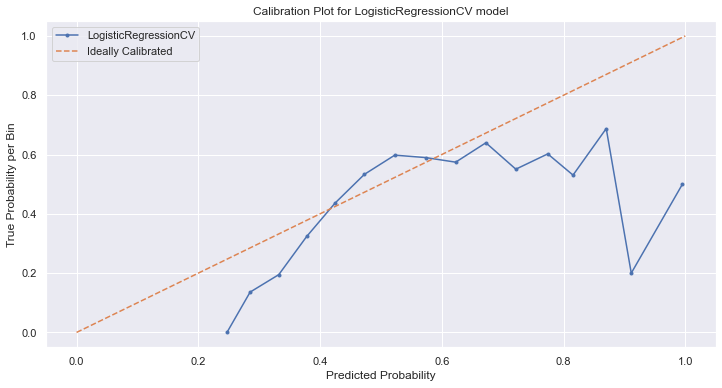

------------------------------------------------------------------------------------------
                         Default Cutoff     cost-minimal Bayes cutoff    Empric minimal cutoff
---------------------  ----------------  ----------------------------  -----------------------
Test Cutoff Threshold          0.5                           0.50944                    0.758
Test Error Cost               12.2944                       12.305                     11.61
Test Accuracy                  0.591433                      0.586233                   0.5449

================================> CONFUSION MATRICES <=====================================


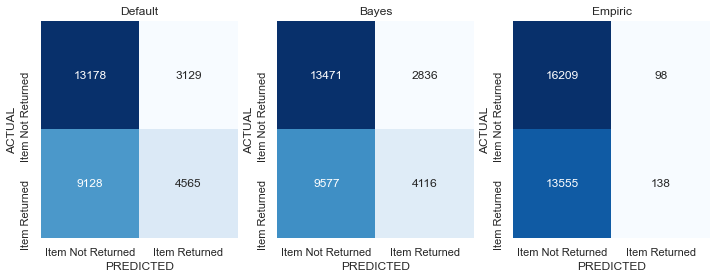


================================> CALIBRATION CURVE (RELIABILITY PLOT) <=====================================


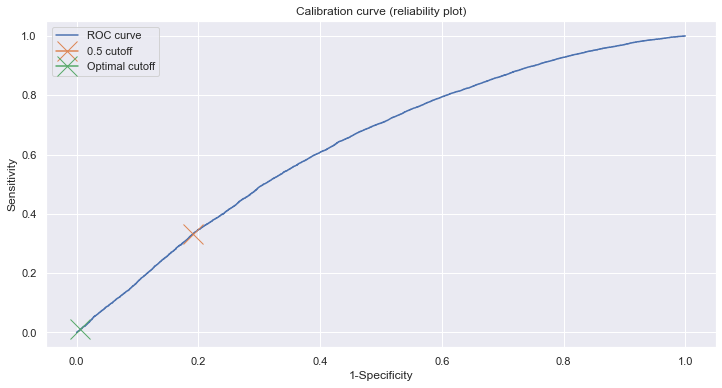


=======================================> FEATURE IMPORTANCE AND ROC <=========================================


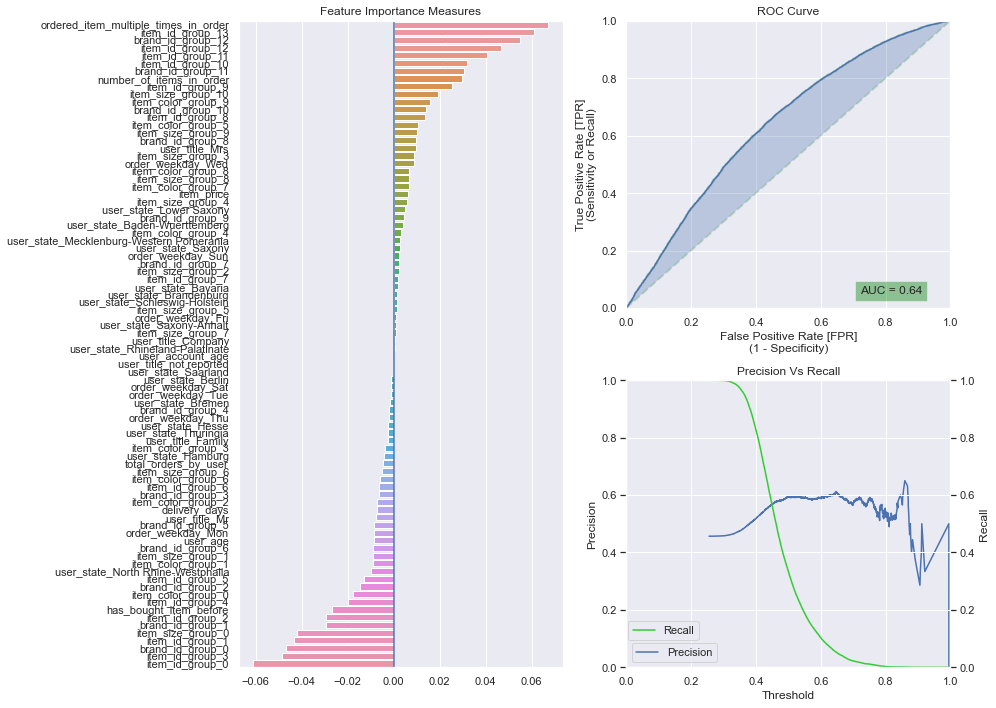

In [22]:
from sklearn.linear_model import LogisticRegressionCV

logit_cv = LogisticRegressionCV(cv=5,
                                n_jobs=-1,
                                random_state=random_seed,
                                refit=True,
                                scoring=custom_cost_scorer,
                               )

logit_cv.fit(x_train, y_train)
logit_report = report(logit_cv, x_train, y_train,
                                x_test, y_test,
                                importance_plot=True,
                                feature_labels=feature_names,
                                confusion_labels=confusion_lbs)

### Discussion:
As expected, the problem domain and the sheer number of features is probably too much for a Logistic Regression Classifier to perform well. While the model did not overfit, thanks to cross validation, it has a fairly low accuracy of ca. 0.6 on the test set and high costs. the model is also not well calibrated which can be seen in the Calibration plot. It struggles with low and high probability values. The confusion matrices also show a similar picture. Since the Classifier is not really well calibrated, the lowest cost cutoff leads to predicting in almost all cases that the item will not be returned. This is a strong sign for a bad classifier. When looking at the Feature Importance plot, the following features seemed to be most important in predicting a return:
- if an item was bought multiple times in one order (`order_item_multiple_times_in_order`)
- various `item_id_groups`'s: 13, 12, 11, 10,...
- the number of items in the order
- ...

In Summary, this Logistic Regression classifier is a bad classifier, both accuracy and cost-sensitive wise.

<a id="random_forrest"></a>
## 3.2  Random Forests

In [23]:
#Import Random Forrest Calssifier and Randomized Search CV for Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

### Randomized Search Parameter Tuning
First we will use a randomized Grid Search with cross folding in order to find the optimal parameters that maximizes `-1 * costs` (keep in mind our custom scorer returns the negative costs). 

In [25]:
## define search space

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = random_seed)

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=random_seed,
                               n_jobs = -1, 
                               scoring=custom_cost_scorer)

# execute search
rf_random.fit(x_train, y_train)
# summarize result
print('Best Score: %s' % rf_random.best_score_)
print('Best Hyperparameters: %s' % rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 79.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 107.3min finished


Best Score: -9.94106992595423
Best Hyperparameters: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}


In [26]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [27]:
# Save best params to txt
f = open('../data/05_model_output/rf_random_best_params.txt','w')
f.write( str(rf_random.best_params_) )
f.close()

### Training

RandomForestClassifier(max_depth=10, max_features=20, min_samples_leaf=2,
                       n_estimators=1800, n_jobs=-1, random_state=420)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 52500 samples
 Test Size: 30000 samples
---------------------------------------------
Train Accuracy:  0.6712761904761905
 Test Accuracy:  0.6525
---------------------------------------------
Train Average Cost:  9.707179161690531
 Test Average Cost:  10.386768100450436
---------------------------------------------
 Area Under ROC (test):  0.7108068761572836
---------------------------------------------
Model Memory Size: 105808.19 kB

=============================> CLASSIFICATION REPORT <===================================
                   precision    recall  f1-score   support

Item Not Returned       0.66      0.76      0.70     16307
    Item Returned       0.65      0.52      0.58     13693

         accuracy                          

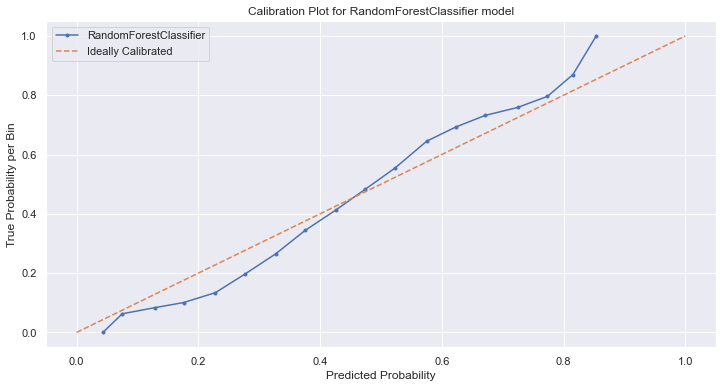

------------------------------------------------------------------------------------------
                         Default Cutoff     cost-minimal Bayes cutoff    Empric minimal cutoff
---------------------  ----------------  ----------------------------  -----------------------
Test Cutoff Threshold            0.5                         0.55872                   0.558
Test Error Cost                 10.3868                      9.90828                   9.90163
Test Accuracy                    0.6525                      0.635867                  0.6362

================================> CONFUSION MATRICES <=====================================


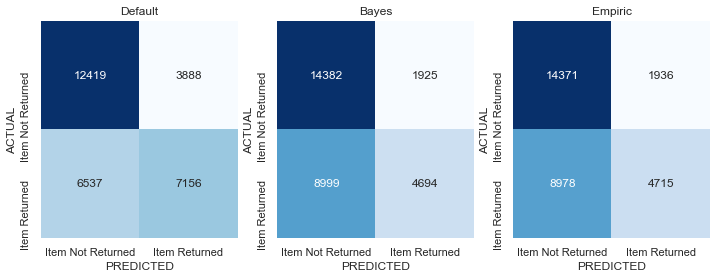


================================> CALIBRATION CURVE (RELIABILITY PLOT) <=====================================


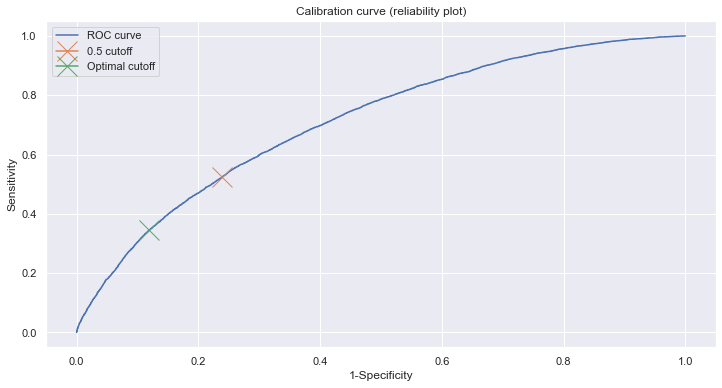


=======================================> FEATURE IMPORTANCE AND ROC <=========================================


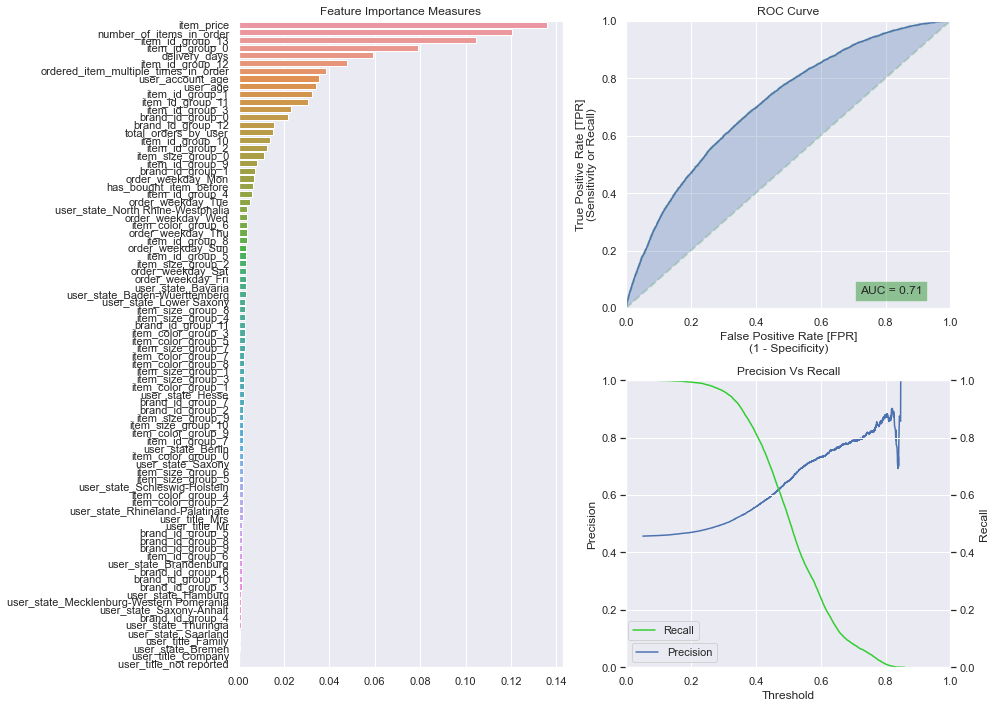

In [24]:
#import RandomForrestClassifier
from sklearn.ensemble import RandomForestClassifier

#Optimal Parameters were extemely overfitting, manually adjusted them to avoid overfitting 
random_forest = RandomForestClassifier(n_estimators=1800,
                                       max_features=20,
                                       max_depth=10,
                                       min_samples_leaf=2,
                                       bootstrap=True,
                                       n_jobs = -1,
                                       random_state = random_seed,
                                      )

random_forest.fit(x_train, y_train)

random_forest_report = report(random_forest, x_train, y_train,
                                             x_test, y_test,
                                             importance_plot=True,
                                             feature_labels=feature_names,
                                             confusion_labels=confusion_lbs)

### Discussion

The Random Forrest Classifier performs significantly better than the Logistic Regression Classifier. While it still true probability per bin still drops of at a predicted probability of around 0.8 and the Confusion Matrices still show that it rather classifies values as non-return to avoid costs, its far better than with the Logistic Regression.

The Calibration Curve shows that the optimal cutoff has lower *sensitivity* and higher *specificity*. This is in line with our asymmetric cost function, which penalizes misclassifying observations as returns more than non-returns. The classifier is hence **less sensitive** towards correctly classifying observations of the **positive class** (return).
Simultaneously, the specificity is slightly lower than normal. This behaviour will be found for all following classifiers and will not be further laid out in following discussions.

Also, the model also does not overfit and still has an acceptable accuracy of 0.63 after using a cost-optimal cutoff threshold. The Feature Importance plot reveals that the most helpful predictor was the price of an item, followed by certain item_id groups, the number of items in an order, if an item was ordered multiple times within an order and the number of delivery days.

In conclusion, the RandomForrest Classifier is certainly an improvement over the Logistic Regression model, however it is highly likely that better results will be achieved by utilizing Ensemble Learning Algorithms.

<a id="xgboost"></a>
## 3.3  XGBoost

In [25]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

### Randomized Search Parameter Tuning

In [29]:
param_grid = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

xgb_rand = RandomizedSearchCV(estimator = XGBClassifier(objective = "binary:logistic"),
                              n_iter = 100,
                              cv = 5,
                              scoring = custom_cost_scorer,
                              param_distributions = param_grid,
                              verbose = 1,
                              random_state = random_seed,
                              refit = True,
                              n_jobs = -1,)
xgb_rand.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 45.1min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc36203ca00>,
                                        'max_depth':

In [43]:
xgb_rand.best_params_

{'colsample_bytree': 0.893653436388291,
 'learning_rate': 0.05085277077791514,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 562,
 'subsample': 0.44899482443790295}

In [33]:
#Save best Params to txt
f = open('../data/05_model_output/xgb_rand_best_params.txt','w')
f.write( str(xgb_rand.best_params_) )
f.close()

### Training

In [26]:
#custom eval metric, used by some algorithms for early stopping to avoid overfitting
def custom_cost_eval_xgb(y_pred, y_true):
    # initiate true y label and prices arrays
    y_true = y_true.get_label()
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    prices = list(x_val['item_price'])
    score = calc_custom_cost_score(y_true, y_pred, prices)
    return ("Cost_Score", score)
    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.805259699363398,
              disable_default_eval_metric=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06774261210446376, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=972, n_jobs=-1, num_parallel_tree=1,
              random_state=420, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9653874758010768, tree_method='exact',
              validate_parameters=1, verbosity=None)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 52500 samples
 Test Size: 30000 samples
---------------------------------------------
Train Accuracy:  0.6684380952380953
 Test Accuracy:  0.6589
---------------------------------------------
Train Average Cost: 

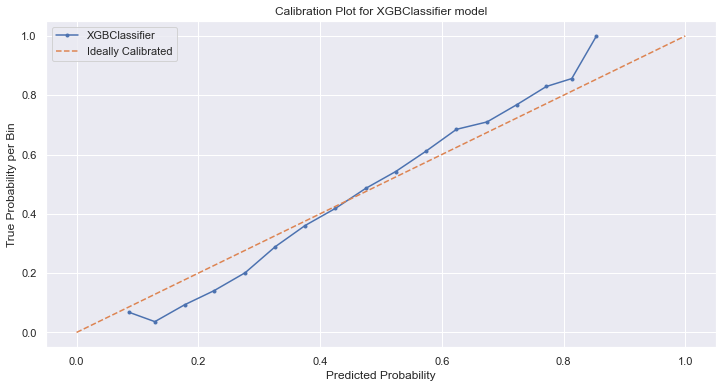

------------------------------------------------------------------------------------------
                         Default Cutoff     cost-minimal Bayes cutoff    Empric minimal cutoff
---------------------  ----------------  ----------------------------  -----------------------
Test Cutoff Threshold            0.5                          0.58421                  0.571
Test Error Cost                 10.2239                       9.78188                  9.68757
Test Accuracy                    0.6589                       0.6365                   0.6434

================================> CONFUSION MATRICES <=====================================


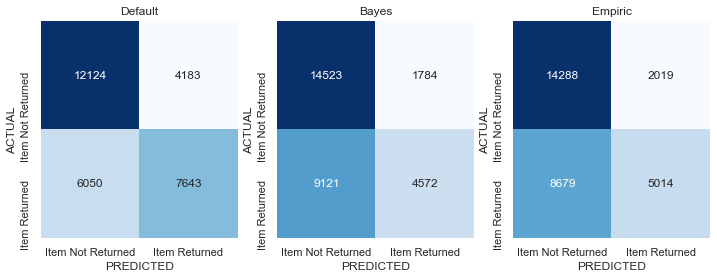


================================> CALIBRATION CURVE (RELIABILITY PLOT) <=====================================


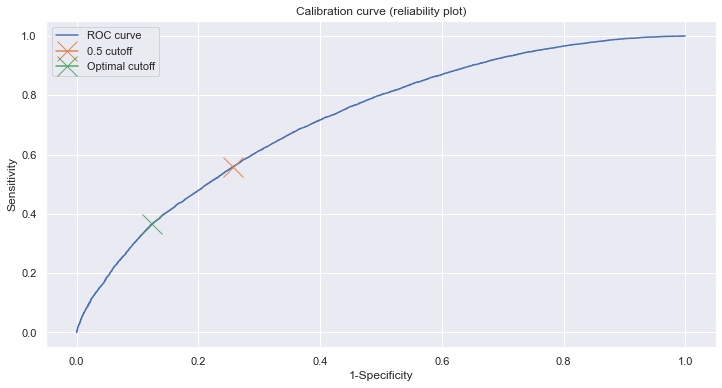


=======================================> FEATURE IMPORTANCE AND ROC <=========================================


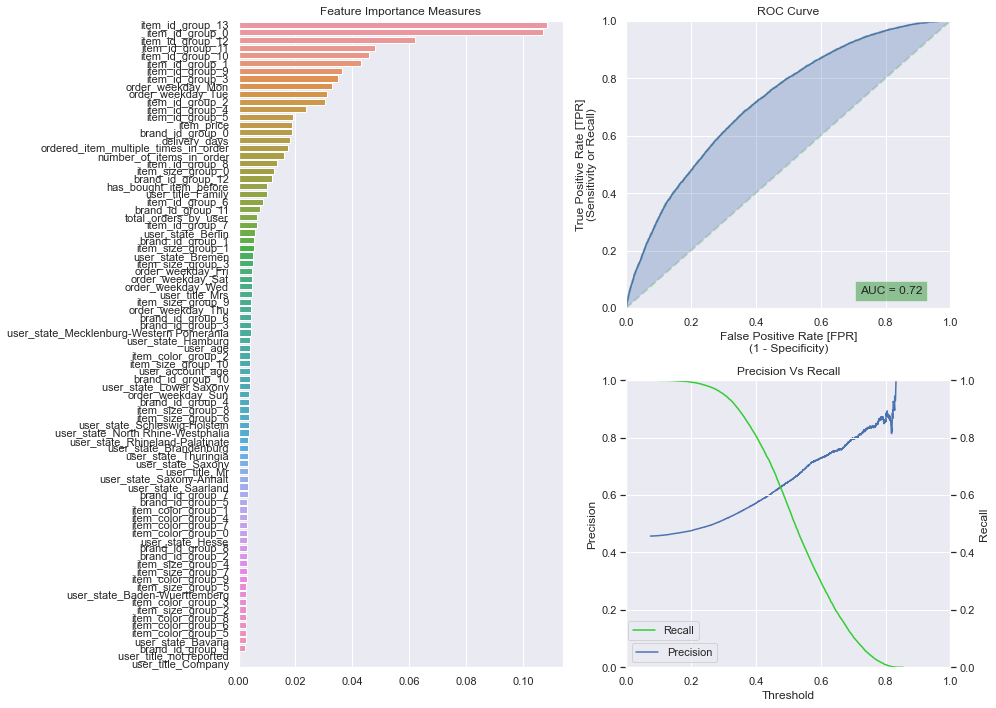

In [27]:
# Note: earlier hyperparameters yielded better results, using them instead of parameters above
xgb_clf = XGBClassifier( 
                        colsample_bytree = 0.805259699363398,
                        learning_rate = 0.06774261210446376,
                        max_depth = 6,
                        min_child_weight = 4,
                        n_estimators=972,
                        subsample= 0.9653874758010768,
                        n_jobs=-1,
                        random_state=random_seed,
                        objective = 'binary:logistic', #2 classifications return <--> no return 
                        disable_default_eval_metric = 1 
                       )

xgb_clf.fit(x_train,
            y_train,
            early_stopping_rounds = 20, # Early Stopping to avoid overfitting
            eval_metric=custom_cost_eval_xgb,
            eval_set=eval_set,
            verbose = False);

xgb_report = report(xgb_clf, x_train, y_train,
                             x_test, y_test,
                             importance_plot=True,
                             feature_labels=feature_names,
                             confusion_labels=confusion_lbs)

### Discussion

Thanks to using a custom evaluation metric function and early stopping, the XGBoost Classifier performed really well. The calibration plot shows that it is near perfect calibrated. the Confusion Matrices show that by using an optimal cutoff, the number of False Negatives, which introduce the highest costs, were dramatically decreased and cut roughly in half. While this also leads to some more False Positves (predicting a user would return an item while they actually were not) this is tolerable, considering our cost matrix. 

<a id="lightgbm"></a>
## 3.4  LightGBM
LightGBM is similar to XGBoost but grows the trees in the ensemble based on Leaf-wise growth algorithm unlike Level-wise algorithm in XGBoost. Its main advantage is that it's training time is very fast, as the name suggest.

In [28]:
from lightgbm import LGBMClassifier

### Finding Optimal Parameters

In [31]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Create the random grid
random_grid ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Initiate LGBM Classifier
gbm = LGBMClassifier(random_state=random_seed, max_depth=-1, n_jobs= -1)

# Initiate Randomized cross validating search
gbm_random = RandomizedSearchCV(estimator = gbm,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=random_seed,
                               n_jobs = -1, 
                               scoring=custom_cost_scorer,
                               refit=True
                               )

# execute search
gbm_random.fit(x_train, y_train)

# summarize result
print('Best Score: %s' % gbm_random.best_score_)
print('Best Hyperparameters: %s' % gbm_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.1s finished


Best Score: -9.993309930984179
Best Hyperparameters: {'colsample_bytree': 0.5331507306847113, 'min_child_samples': 163, 'min_child_weight': 0.1, 'num_leaves': 42, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.30291861982300505}


In [37]:
#Save best Params to txt
f = open('../data/05_model_output/gbm_random_best_params.txt','w')
f.write( str(gbm_random.best_params_) )
f.close()

### Training

In [29]:
#custom eval metric for LGBM
def custom_cost_eval_lgbm(y_true, y_pred):

    y_pred = np.where(y_pred >= 0.5, 1, 0)
    prices = list(x_val['item_price'])
    
    score = calc_custom_cost_score(y_true, y_pred, prices)
    return ("Cost_Score", score, False)
    

LGBMClassifier(colsample_bytree=0.5331507306847113, min_child_samples=163,
               min_child_weight=0.1, num_leaves=42, random_state=420,
               reg_alpha=0.1, reg_lambda=0, subsample=0.30291861982300505)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 52500 samples
 Test Size: 30000 samples
---------------------------------------------
Train Accuracy:  0.6957714285714286
 Test Accuracy:  0.6701
---------------------------------------------
Train Average Cost:  9.14519802220776
 Test Average Cost:  9.985560439727704
---------------------------------------------
 Area Under ROC (test):  0.7337045670800441
---------------------------------------------
Model Memory Size: 468.44 kB

=============================> CLASSIFICATION REPORT <===================================
                   precision    recall  f1-score   support

Item Not Returned       0.69      0.72      0.70     16307
    Item Returned       0.65     

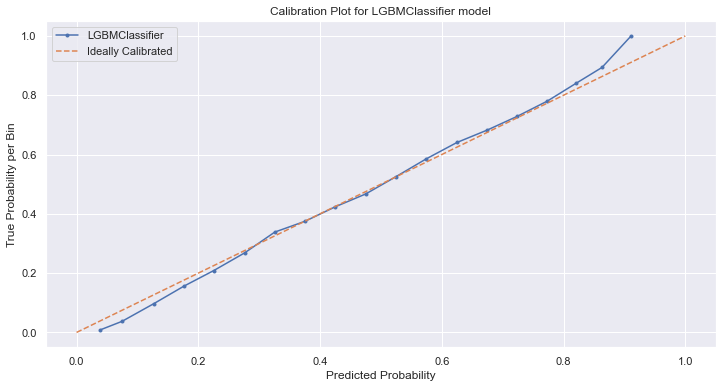

------------------------------------------------------------------------------------------
                         Default Cutoff     cost-minimal Bayes cutoff    Empric minimal cutoff
---------------------  ----------------  ----------------------------  -----------------------
Test Cutoff Threshold           0.5                          0.61884                   0.569
Test Error Cost                 9.98556                      9.63497                   9.56449
Test Accuracy                   0.6701                       0.643967                  0.662

================================> CONFUSION MATRICES <=====================================


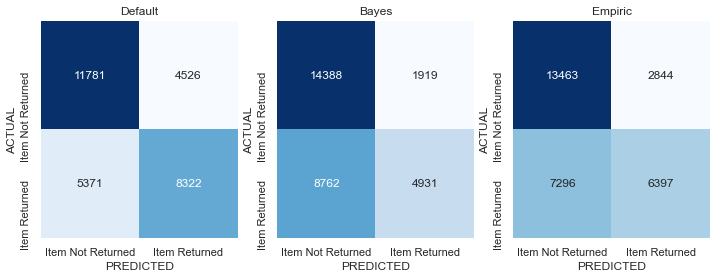


================================> CALIBRATION CURVE (RELIABILITY PLOT) <=====================================


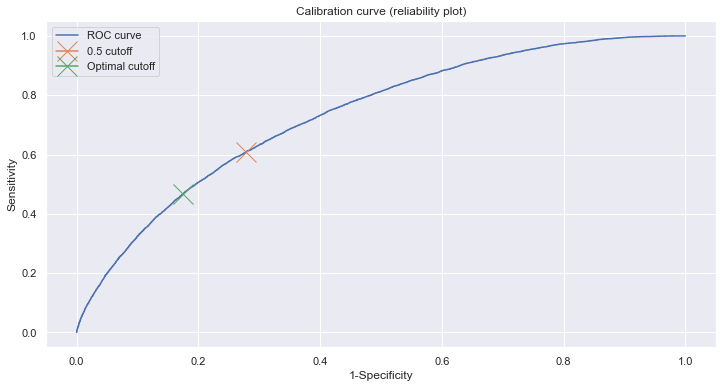


=======================================> FEATURE IMPORTANCE AND ROC <=========================================


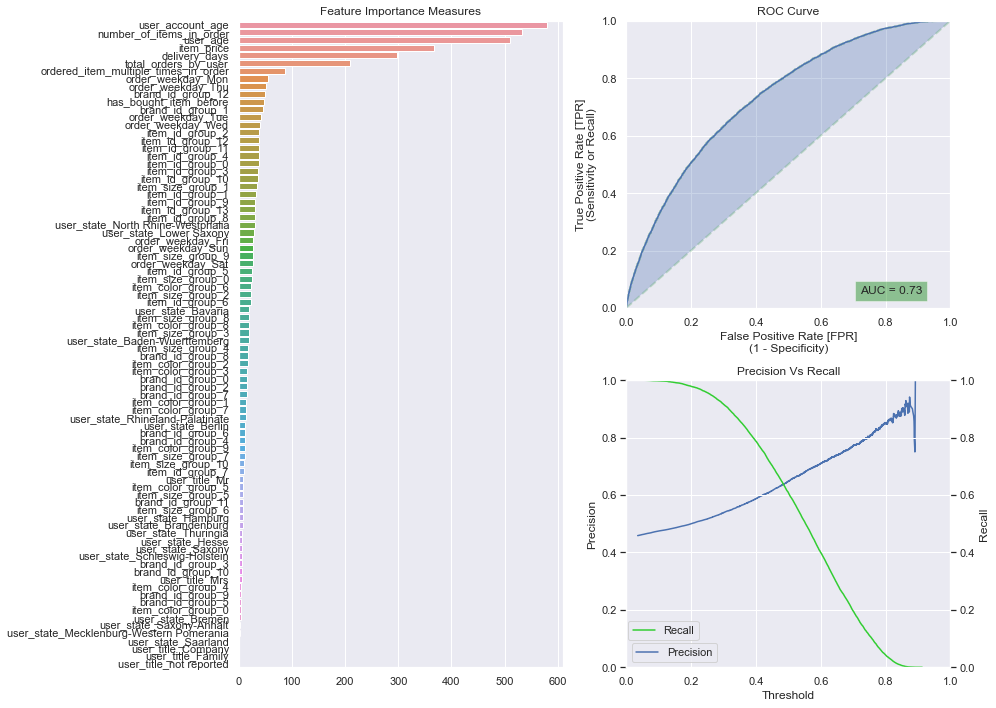

In [30]:
lgbm_clf = LGBMClassifier(random_state=random_seed,
                          n_jobs=-1,
                          colsample_bytree =  0.5331507306847113,
                          min_child_samples= 163,
                          min_child_weight = 0.1,
                          num_leaves = 42,
                          reg_alpha = 0.1,
                          reg_lambda=0,
                          subsample =  0.30291861982300505,
                     )
lgbm_clf.fit(x_train, y_train, eval_set = eval_set, eval_metric = custom_cost_eval_lgbm, verbose=False);

lgbm_report = report(lgbm_clf, x_train, y_train,
                               x_test, y_test,
                               importance_plot=True,
                               feature_labels=feature_names,
                               confusion_labels=confusion_lbs)

### Discussion

Apart from a minor dip in true probabilities per bin, the LGBM Classifier also seems to be very well calibrated. Again, thanks to a custom evaluation metric and set, the Classifier is barely overfitting. Just like with XGBoost, using a cost-optimal threshold cut-off, the number of False Positives have been halved. Even with such a threshold, the model is still fairly accurate (0.661367 on the test set). 

Interestingly, this classifier deemed other features to be more important than the previous classifiers. It put more emphasize on numeric variables such as `user_account_age`, `number_of_items_in_order`, `user_age`, `item_price`, `delivery_days` and `total_orders_by_user`.

In summary, the LGBM seems to be a very promising Classifier, yielding fairly high accuracy while minimizing the costs.

<a id="catboost"></a>
## 3.5  CatBoost
Cat boost performs better without One-hot encoding because it performs an internal categorical encoding that is similar to Leave One Out Encoding (LOOE). Therefore, we insert a different test and train set which has been prepared at the beginning of this notebook.

In [31]:
from catboost import CatBoostClassifier

### Find Optimal Hyper Parameters 

In [33]:
random_grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],}
cat = CatBoostClassifier(random_state=random_seed,)

cat_random = RandomizedSearchCV(estimator = cat,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose=2,
                               random_state=random_seed,
                               n_jobs = -1, 
                               scoring=custom_cost_scorer,
                               refit=True
                               )

# execute search
cat_random.fit(x_train, y_train)
# summarize result
print('Best Score: %s' % cat_random.best_score_)
print('Best Hyperparameters: %s' % cat_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.3min finished


0:	learn: 0.6894096	total: 95.5ms	remaining: 1m 35s
1:	learn: 0.6864531	total: 113ms	remaining: 56.2s
2:	learn: 0.6832421	total: 129ms	remaining: 42.8s
3:	learn: 0.6805944	total: 145ms	remaining: 36s
4:	learn: 0.6776526	total: 160ms	remaining: 31.8s
5:	learn: 0.6749946	total: 174ms	remaining: 28.8s
6:	learn: 0.6730010	total: 189ms	remaining: 26.8s
7:	learn: 0.6707289	total: 204ms	remaining: 25.3s
8:	learn: 0.6679914	total: 219ms	remaining: 24.1s
9:	learn: 0.6658719	total: 235ms	remaining: 23.3s
10:	learn: 0.6635534	total: 249ms	remaining: 22.4s
11:	learn: 0.6619264	total: 266ms	remaining: 21.9s
12:	learn: 0.6603427	total: 279ms	remaining: 21.2s
13:	learn: 0.6585698	total: 297ms	remaining: 20.9s
14:	learn: 0.6562330	total: 316ms	remaining: 20.8s
15:	learn: 0.6548359	total: 333ms	remaining: 20.5s
16:	learn: 0.6529762	total: 349ms	remaining: 20.2s
17:	learn: 0.6514509	total: 366ms	remaining: 20s
18:	learn: 0.6495605	total: 381ms	remaining: 19.7s
19:	learn: 0.6482338	total: 398ms	remaining

173:	learn: 0.5906706	total: 2.78s	remaining: 13.2s
174:	learn: 0.5905378	total: 2.79s	remaining: 13.2s
175:	learn: 0.5904174	total: 2.81s	remaining: 13.2s
176:	learn: 0.5902509	total: 2.83s	remaining: 13.1s
177:	learn: 0.5901293	total: 2.84s	remaining: 13.1s
178:	learn: 0.5899360	total: 2.85s	remaining: 13.1s
179:	learn: 0.5897222	total: 2.87s	remaining: 13.1s
180:	learn: 0.5895989	total: 2.89s	remaining: 13.1s
181:	learn: 0.5894284	total: 2.9s	remaining: 13s
182:	learn: 0.5892002	total: 2.92s	remaining: 13s
183:	learn: 0.5890834	total: 2.93s	remaining: 13s
184:	learn: 0.5889673	total: 2.95s	remaining: 13s
185:	learn: 0.5887565	total: 2.96s	remaining: 13s
186:	learn: 0.5885957	total: 2.98s	remaining: 12.9s
187:	learn: 0.5884511	total: 2.99s	remaining: 12.9s
188:	learn: 0.5883190	total: 3.01s	remaining: 12.9s
189:	learn: 0.5881835	total: 3.02s	remaining: 12.9s
190:	learn: 0.5880080	total: 3.04s	remaining: 12.9s
191:	learn: 0.5878642	total: 3.05s	remaining: 12.9s
192:	learn: 0.5877723	t

341:	learn: 0.5660290	total: 5.43s	remaining: 10.5s
342:	learn: 0.5659027	total: 5.45s	remaining: 10.4s
343:	learn: 0.5657682	total: 5.47s	remaining: 10.4s
344:	learn: 0.5656861	total: 5.48s	remaining: 10.4s
345:	learn: 0.5655485	total: 5.5s	remaining: 10.4s
346:	learn: 0.5654311	total: 5.51s	remaining: 10.4s
347:	learn: 0.5652499	total: 5.53s	remaining: 10.4s
348:	learn: 0.5650906	total: 5.54s	remaining: 10.3s
349:	learn: 0.5649679	total: 5.55s	remaining: 10.3s
350:	learn: 0.5648461	total: 5.57s	remaining: 10.3s
351:	learn: 0.5646620	total: 5.59s	remaining: 10.3s
352:	learn: 0.5645286	total: 5.61s	remaining: 10.3s
353:	learn: 0.5644273	total: 5.62s	remaining: 10.3s
354:	learn: 0.5643367	total: 5.64s	remaining: 10.2s
355:	learn: 0.5642107	total: 5.65s	remaining: 10.2s
356:	learn: 0.5640581	total: 5.67s	remaining: 10.2s
357:	learn: 0.5639379	total: 5.68s	remaining: 10.2s
358:	learn: 0.5638100	total: 5.7s	remaining: 10.2s
359:	learn: 0.5637101	total: 5.71s	remaining: 10.2s
360:	learn: 0.

509:	learn: 0.5409759	total: 8.04s	remaining: 7.72s
510:	learn: 0.5408401	total: 8.05s	remaining: 7.71s
511:	learn: 0.5406923	total: 8.07s	remaining: 7.69s
512:	learn: 0.5405581	total: 8.08s	remaining: 7.67s
513:	learn: 0.5404250	total: 8.1s	remaining: 7.66s
514:	learn: 0.5402604	total: 8.11s	remaining: 7.64s
515:	learn: 0.5401670	total: 8.13s	remaining: 7.62s
516:	learn: 0.5400306	total: 8.14s	remaining: 7.61s
517:	learn: 0.5399154	total: 8.16s	remaining: 7.59s
518:	learn: 0.5397914	total: 8.17s	remaining: 7.57s
519:	learn: 0.5396201	total: 8.19s	remaining: 7.56s
520:	learn: 0.5394679	total: 8.2s	remaining: 7.54s
521:	learn: 0.5393634	total: 8.21s	remaining: 7.52s
522:	learn: 0.5391808	total: 8.23s	remaining: 7.51s
523:	learn: 0.5390026	total: 8.25s	remaining: 7.49s
524:	learn: 0.5388400	total: 8.26s	remaining: 7.48s
525:	learn: 0.5386989	total: 8.28s	remaining: 7.46s
526:	learn: 0.5384811	total: 8.29s	remaining: 7.45s
527:	learn: 0.5383216	total: 8.31s	remaining: 7.43s
528:	learn: 0.

670:	learn: 0.5188476	total: 10.5s	remaining: 5.16s
671:	learn: 0.5187049	total: 10.5s	remaining: 5.14s
672:	learn: 0.5186029	total: 10.5s	remaining: 5.12s
673:	learn: 0.5184903	total: 10.6s	remaining: 5.11s
674:	learn: 0.5183845	total: 10.6s	remaining: 5.09s
675:	learn: 0.5182666	total: 10.6s	remaining: 5.08s
676:	learn: 0.5181097	total: 10.6s	remaining: 5.06s
677:	learn: 0.5179848	total: 10.6s	remaining: 5.04s
678:	learn: 0.5178510	total: 10.6s	remaining: 5.03s
679:	learn: 0.5177237	total: 10.6s	remaining: 5.01s
680:	learn: 0.5176113	total: 10.7s	remaining: 4.99s
681:	learn: 0.5174763	total: 10.7s	remaining: 4.98s
682:	learn: 0.5173629	total: 10.7s	remaining: 4.96s
683:	learn: 0.5171865	total: 10.7s	remaining: 4.95s
684:	learn: 0.5170161	total: 10.7s	remaining: 4.93s
685:	learn: 0.5168847	total: 10.7s	remaining: 4.92s
686:	learn: 0.5167801	total: 10.8s	remaining: 4.9s
687:	learn: 0.5166451	total: 10.8s	remaining: 4.88s
688:	learn: 0.5165531	total: 10.8s	remaining: 4.87s
689:	learn: 0

832:	learn: 0.4991978	total: 13s	remaining: 2.6s
833:	learn: 0.4990647	total: 13s	remaining: 2.58s
834:	learn: 0.4989213	total: 13s	remaining: 2.57s
835:	learn: 0.4988158	total: 13s	remaining: 2.55s
836:	learn: 0.4986709	total: 13s	remaining: 2.54s
837:	learn: 0.4985122	total: 13.1s	remaining: 2.52s
838:	learn: 0.4984135	total: 13.1s	remaining: 2.51s
839:	learn: 0.4983102	total: 13.1s	remaining: 2.49s
840:	learn: 0.4981658	total: 13.1s	remaining: 2.48s
841:	learn: 0.4980475	total: 13.1s	remaining: 2.46s
842:	learn: 0.4978998	total: 13.1s	remaining: 2.44s
843:	learn: 0.4978132	total: 13.1s	remaining: 2.43s
844:	learn: 0.4976702	total: 13.2s	remaining: 2.41s
845:	learn: 0.4975775	total: 13.2s	remaining: 2.4s
846:	learn: 0.4974637	total: 13.2s	remaining: 2.38s
847:	learn: 0.4973106	total: 13.2s	remaining: 2.37s
848:	learn: 0.4972298	total: 13.2s	remaining: 2.35s
849:	learn: 0.4971530	total: 13.2s	remaining: 2.33s
850:	learn: 0.4970422	total: 13.2s	remaining: 2.32s
851:	learn: 0.4969405	to

991:	learn: 0.4812347	total: 15.4s	remaining: 124ms
992:	learn: 0.4811451	total: 15.4s	remaining: 109ms
993:	learn: 0.4810514	total: 15.5s	remaining: 93.3ms
994:	learn: 0.4809303	total: 15.5s	remaining: 77.8ms
995:	learn: 0.4808412	total: 15.5s	remaining: 62.2ms
996:	learn: 0.4807376	total: 15.5s	remaining: 46.7ms
997:	learn: 0.4806444	total: 15.5s	remaining: 31.1ms
998:	learn: 0.4805532	total: 15.5s	remaining: 15.6ms
999:	learn: 0.4804388	total: 15.6s	remaining: 0us
Best Score: -9.899649309831574
Best Hyperparameters: {'learning_rate': 0.03, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 9, 'border_count': 20}


In [37]:
#Save best Params to txt
f = open('../data/05_model_output/gbm_random_best_params.txt','w')
f.write( str(cat_random.best_params_) )
f.close()

In [32]:
# Cat Boost requires a custom CostMetric Class to evaluate results
class CostMetric:
    
    @staticmethod
    def get_profit(y_true, y_pred):
        y_pred = np.where(y_pred >= 0.5 ,1, 0)
        y_true = np.array(y_true)
        costs = calc_custom_cost_score(y_true, y_pred, list(x_train['item_price']))
        return costs
    
    def is_max_optimal(self):
        return False # lower is better

    def evaluate(self, approxes, target, weight):            
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        y_true = np.array(target).astype(int)
        approx = approxes[0]
        score = self.get_profit(y_true, approx)
        return score, 1

    def get_final_error(self, error, weight):
        return error


=============================> TRAIN-TEST DETAILS <======================================
Train Size: 52500 samples
 Test Size: 30000 samples
---------------------------------------------
Train Accuracy:  0.6616380952380952
 Test Accuracy:  0.6585
---------------------------------------------
Train Average Cost:  10.017346452053388
 Test Average Cost:  10.222073187353214
---------------------------------------------
 Area Under ROC (test):  0.7184411550429375
---------------------------------------------
Model Memory Size: 676.96 kB

=============================> CLASSIFICATION REPORT <===================================
                   precision    recall  f1-score   support

Item Not Returned       0.67      0.74      0.70     16307
    Item Returned       0.64      0.56      0.60     13693

         accuracy                           0.66     30000
        macro avg       0.66      0.65      0.65     30000
     weighted avg       0.66      0.66      0.66     30000


===========

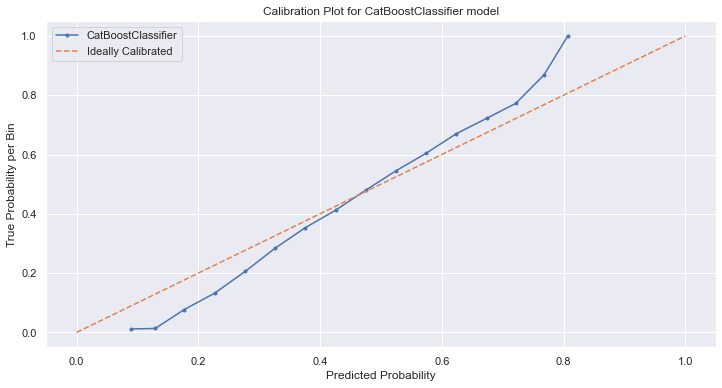

------------------------------------------------------------------------------------------
                         Default Cutoff     cost-minimal Bayes cutoff    Empric minimal cutoff
---------------------  ----------------  ----------------------------  -----------------------
Test Cutoff Threshold            0.5                         0.58215                  0.556
Test Error Cost                 10.2221                      9.85035                  9.8195
Test Accuracy                    0.6585                      0.636333                 0.647033

================================> CONFUSION MATRICES <=====================================


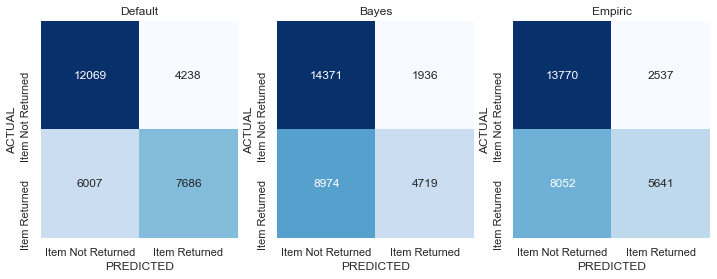


================================> CALIBRATION CURVE (RELIABILITY PLOT) <=====================================


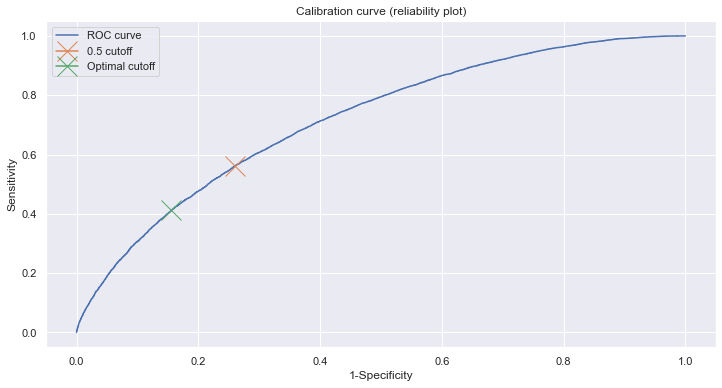


=======================================> FEATURE IMPORTANCE AND ROC <=========================================


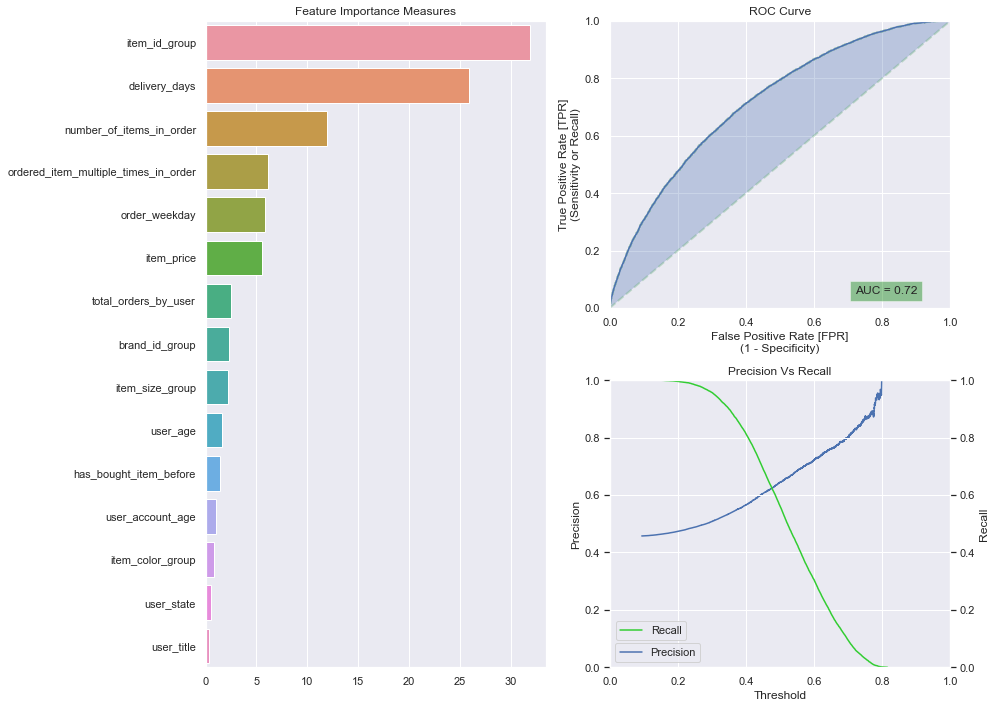

In [33]:
catboost_clf = CatBoostClassifier(cat_features=categorical_columns_cat,
                                  learning_rate=0.03,
                                  l2_leaf_reg=10,
                                  iterations = 1000,
                                  depth = 9,
                                  border_count= 20,
                                  allow_writing_files=False,
                                  silent=True,
                                  use_best_model=True,
                                  random_state=random_seed,
                                  eval_metric=CostMetric())

catboost_clf.fit(x_train_cat, y_train, 
                 eval_set=eval_set_cat,
                 logging_level = 'Silent',
                 early_stopping_rounds=20,
                 
            )


f_labels = feature_names_cat
catboost_report = report(catboost_clf, x_train_cat, y_train_cat,
                                       x_test_cat, y_test_cat,
                                       importance_plot=True,
                                       feature_labels=f_labels,
                                       confusion_labels=confusion_lbs)

### Discussion
Cat Boost performed almost identically to LGBM. Note the different appearance of the Feature Importance Plot. Since The CatBoost Classifier handles categorical variables itself, feature importances are displayed for the whole column, not individual feature levels. While it also deemed most of the numeric columns important for classification, the feature with the highest importance is the `item_id_group`.   

<a id="model_comparison"></a>
# 4.  Model Comparison and Evaluation

In [82]:
report_list = [logit_report,                 
               random_forest_report, 
               xgb_report, 
               lgbm_report, 
               catboost_report
               ]

In [37]:
# Model list
models = [  logit_cv,
            random_forest,
            xgb_clf,
            lgbm_clf,
            catboost_clf
         ]

# Save models
import pickle

for model in models:
    with open(f'../data/04_models/{model.__class__.__name__ }', 'wb') as file:
        pickle.dump(model, file)

In [ ]:
compare_table = compare_models(y_test, clf_reports=report_list)
compare_table.sort_values(by=['Total Cost'], inplace = True)
compare_table

In [83]:
compare_table = compare_models(y_test, clf_reports=report_list)
compare_table.sort_values(by=['Total Cost'], inplace = True)
compare_table

,Memory Size,Train Accuracy,Test Accuracy,ROC AUC,Optimal Cutoff,Total Cost
LGBMClassifier,468.44,0.695771,0.670100,0.733705,0.569,9.564491
XGBClassifier,259.78,0.668438,0.658900,0.721710,0.571,9.687565
CatBoostClassifier,676.96,0.661638,0.658500,0.718441,0.556,9.819502
RandomForestClassifier,105808.19,0.671276,0.652500,0.710807,0.558,9.901625
LogisticRegressionCV,35.72,0.591086,0.591433,0.638840,0.758,11.610029


In [210]:
# save reults
now = datetime.now()

compare_table.to_csv(f'../data/06_reporting/Comparison_Table_{now}.csv')

### Discussion
None of the models above were over or underfitting. The advantages of ensemble learning really came into fruition here, since the use of a custom evaluation metric and set greatly improved cost reduction. 

The best Classifier was the LGBMClassifier, yielding a test accuracy of 0.67 and Costs of 9.49 with an optimal cut-off of 0.578.

Another interesting observation is that the RandomForrestClassifier has a huge memory size compared to the others, suggesting many splits happened during training.

<a id="pdp"></a>
## 4.1 Partial dependence analysis

Using partial dependence analysis, we can examine the marginal effects of features on model predictions. This can help identifying which features had positive or negative impact on predictions and also to identify which features did not have any effect on model predictions.

In [56]:
from sklearn.inspection import plot_partial_dependence

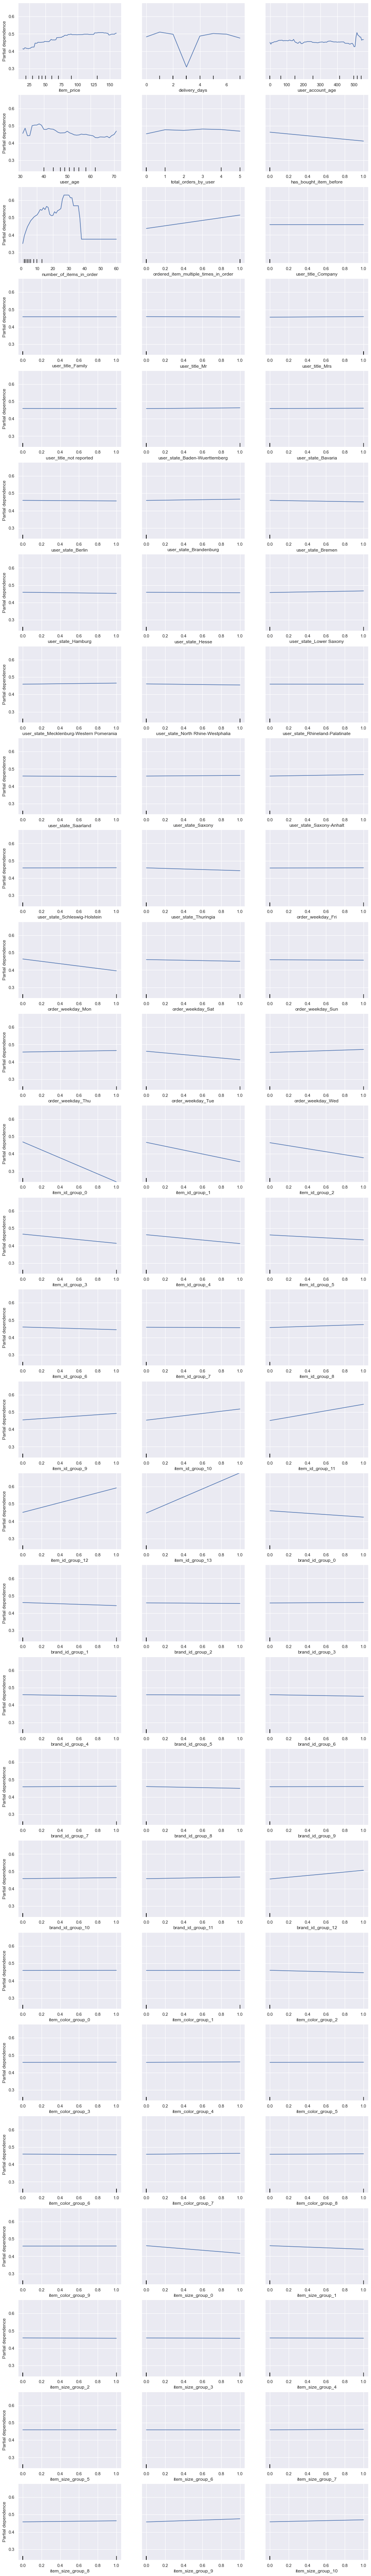

In [57]:
plt.rcParams['figure.figsize'] = 16,120
plot_partial_dependence(lgbm_clf, x_train, features=x_test.columns, feature_names=feature_names);

Certain item and brand id groups show a monotonic increase or decrease, indicating a consistant feature-to-target relationship. 
However, there are also many features with horizontal lines, indicating that changes in these values do not change the feature variable, suggesting that they could be discarded. Unfortunately, due to time limits, we will not pursue this train of thought, but it is good to know that there are further possible improvements to be made to our modeling approach.

<a id="shap"></a>
## 4.2 Shap

In [58]:
# Import shap 
import shap

In [59]:
# Chose row/ observation and extract values
test_point = 1

In [64]:
# Explainer algorithm  for tree models
explainer_lgbm = shap.TreeExplainer(lgbm_clf, data=x_train, feature_perturbation='interventional', model_output='probability')

# Calculate SHAP values for all observations
shap_values_lgbm = explainer_lgbm.shap_values(x_test)

100%|===================| 29865/30000 [02:07<00:00]        

In [65]:
print("The shape of the LGBM model is: {}".format(np.shape(shap_values_lgbm)))

The shape of the LGBM model is: (30000, 84)


In [66]:
# Local explanation SHAP plot for LGBM model
shap.initjs()
shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm[test_point], x_test.values[test_point], feature_names=x_test.columns)

The LGBM model predicts a default probability of the `test_point` of **0.41**. 

At this value, if users ordered multiple items, the probability of a return decreased. This is rather unexpected as you would assume that ordering the same item multiple times in different sizes would mean that at least one of them gets returned.

Interestingly orders made on a Wednesday seemed to have increased the probability.

Finally lets take a look at some of the item_groups and item_size_groups that increased or decreased the probability. Luckily, in our Feature engineering step we saved the mapping of bins to their actual corresponding values, making it easy to inspect which items were actually part of a binning group.

In [67]:
import json

In [68]:
# Load item_id_group_mapping
with open('../data/03_processed/item_id_bin_map.json') as f:
    item_id_group_mapping = json.load(f)

In [74]:
#Item_id's of group 0, susbtantial increase of predictions
print(item_id_group_mapping['0'])

[1118, 2054, 2055, 1417, 1125, 1323, 365, 667, 1262, 1994, 847, 196, 2094, 2167, 2043, 2124, 2121, 2176, 2162, 1090, 1129, 2159, 1170, 1774, 2137, 787, 784, 778, 2146, 2103, 2147, 2148, 2025, 881, 2152, 869, 2021, 1133, 2158, 2160, 421, 1342, 2238, 2114, 1926, 2117, 927, 1041, 521, 2115, 2209, 1947, 1951, 2080, 2083, 2085, 945, 2219, 1443, 2184, 2181, 2226, 2229, 1914, 1439, 953, 1062, 2218, 1868, 2108, 2100, 1957, 493, 1436, 746, 1446, 253, 1447, 639, 11, 1117, 1723, 1997, 1904, 2071, 935, 2154, 240, 1907, 485, 1992, 843, 2065, 345, 1746, 31, 2067, 1707, 2156, 2007, 250, 59, 36, 2101, 2199, 970, 1602, 634, 1748, 889, 1946, 615, 2173, 661, 2006, 2196, 110, 175, 219, 139, 1757, 1427, 1475, 1116, 1991, 1423, 62, 1911, 1509, 1920, 562, 1873, 2077, 2165, 482, 799, 2018, 2022, 2072, 1783, 88, 181, 630, 2027, 1084, 1943, 1473, 119, 192, 2135, 1629, 28, 261, 897, 1809, 1773, 280, 592]


In [73]:
#Item_id`s of group 5, susbtantial decrease of predictions
print(item_id_group_mapping['5'])

[625, 121, 223, 1512, 1604, 1525, 1476, 328, 1855, 158, 2070, 1668, 1500, 561, 1856, 354, 136, 1993, 1498, 165, 1093, 1632, 1963, 190, 298, 1683, 508, 2, 212, 736, 1688, 1804, 1612, 140, 135, 235, 462, 2086, 90, 1980, 2051, 457, 837, 2079, 134, 899, 1952, 1528, 1987, 1985, 1853, 2136, 1870, 1919, 759, 1823, 538, 2163, 2002, 1124, 1187, 255, 94, 226, 1506, 98, 103, 1672, 113, 1635, 205, 1466, 486, 2084, 577, 1871, 666, 396, 370, 665, 1597, 931, 1838, 116, 1867, 425, 2061]


Saving the mapping of id's and bins now makes it possible to inspect which items, brands, colors or sizes lead to higher / lower return rates.

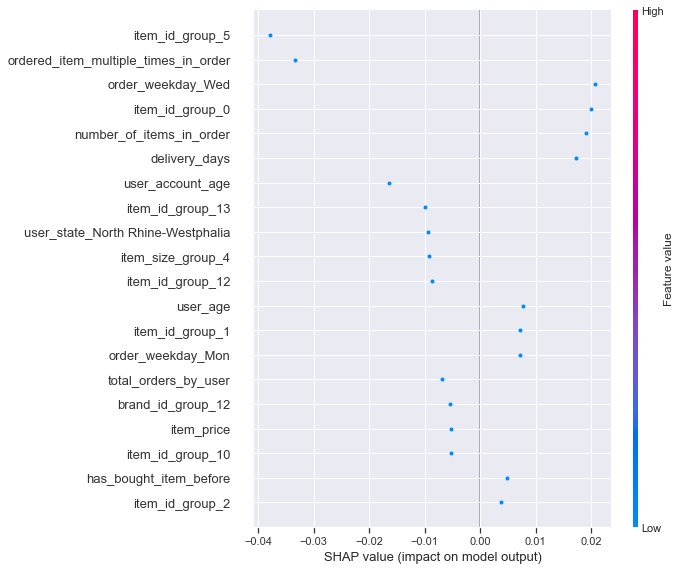

In [75]:
# Summary plot for single observation, LGBM model
shap.summary_plot(shap_values_lgbm[test_point].reshape(1, -1), x_test.values[test_point].reshape(1, -1), feature_names=x_test.columns)

Displays feature impact on model predictions. Value of a feature is depicted on the y axis, while the impact on model predictions is shown on the x axis. Shows similar results as previously discussed.

<a id="export"></a>
# 5. Export Predictions
Finally we will generate predictions on the unknown Dataset using the best Classifier and the corresponding optimal cutoff.

In [53]:
# get best cut_off
best_cutoff = compare_table['Optimal Cutoff'][0]
best_cutoff

0.5690000000000001

In [54]:
# predict prbabilities for unlabelled dataset 
pred_unknown = lgbm_clf.predict_proba(df_unknown)[:,1]

# generate discrete predictions using the best_cutoff
discrete_pred_unknown = np.where(pred_unknown >= best_cutoff, 1, 0)

#save as pandas series in correct format
predictions = pd.Series(discrete_pred_unknown, index=df_unknown.index, name='return')

<AxesSubplot:xlabel='return', ylabel='count'>

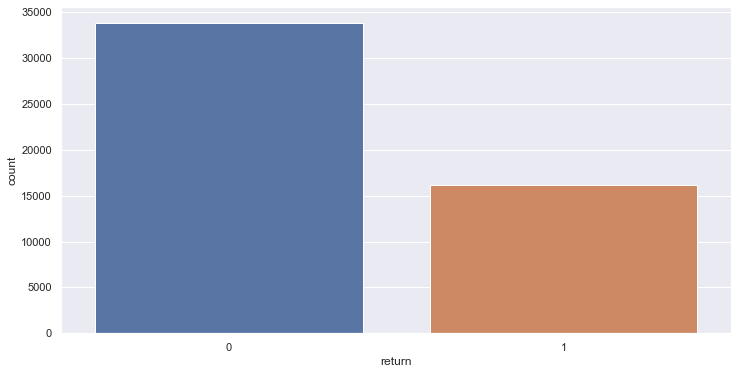

In [55]:
sns.countplot(x=predictions)

We know that the dataset has been artificially balanced, containing the same number of returns as non returns. However, due to the asymmetric cost function, this distribution of returns and non returns seems reasonable (roughly 1/3 return 2/3 non returns).

### AUC Score of Unlabelled Dataset
According to Kaggle, these Predictions for the unlabelled data lead to the following AUC scores:

- Private: **0.63853**
- Public: **0.63672**

Considering we used a cost-optimal threshold cut-off these scores are pretty good! The also seem to be in line with the ROC Score on our testing set, suggesting the model is well calibrated and trained.

In [61]:
# Sanity checks to see if predictions are discrete
print(predictions.unique())
print(len(predictions))
print(predictions)

[1 0]
50000
order_item_id
100001    1
100002    1
100003    1
100004    0
100005    0
         ..
149996    1
149997    0
149998    1
149999    0
150000    0
Name: return, Length: 50000, dtype: int64


In [62]:
# save predictions to CSV
predictions.to_csv('../results/predictions.csv')

In [63]:
#second sanity check to confirm data can is loaded correctly 
test_import = pd.read_csv('../results/predictions.csv', index_col=0)
test_import

,return
order_item_id,
100001,1
100002,1
100003,1
100004,0
100005,0
...,...
149996,1
149997,0
149998,1
